In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from tqdm import trange
from torch.distributions.normal import Normal
from bnn import BayesBaseModule, BayesConv2d, BayesLinear, BayesModel
from torch.distributions.laplace import Laplace

## Distributions and model

In [3]:
distr = Normal(torch.tensor(0.), torch.tensor(1.))

In [4]:
class NormalModel(nn.Module):
    def __init__(self, 
                 weight_distribution,
                 bias_distribution):
        super().__init__()
        self.conv_0 = BayesConv2d(weight_distribution, bias_distribution, 
                                  in_channels=1, out_channels=64, kernel_size=3)
        self.conv_1 = BayesConv2d(weight_distribution, bias_distribution, 
                                  in_channels=64, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2)
        self.fc = BayesLinear(weight_distribution, bias_distribution, in_features=1600, out_features=10)
        self._weight_distribution = weight_distribution
        self._bias_distribution = bias_distribution
        
    def weight_distribution(self):
        return self._weight_distribution
    
    def bias_distribution(self):
        return self._bias_distribution
    
    def weight(self):
        return self.weight
        
    def log_prior(self):
        log_p = 0
        for m in self.modules():
            if isinstance(m, (BayesLinear, BayesConv2d)):
                log_p += m.log_prior()
                
        return log_p

    def forward(self, x):
        x = self.relu(self.conv_0(x))
        x = self.pooling(x)
        x = self.relu(self.conv_1(x))
        x = self.pooling(x)
        x = x.view(-1, 1600)
        x = self.fc(x)
        return x

In [5]:
mdl = NormalModel(weight_distribution = distr,
                 bias_distribution = distr)

## Dataset

In [6]:
dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

In [7]:
dataset[0][0].shape

torch.Size([1, 28, 28])

## Train

### Multivariate Normal (0, I)

In [8]:
temperature = 1
trainer = BayesModel(train_dataset=train_set,
                    test_dataset=val_set,
                    batch_size=128,
                    architecture=mdl,
                    lr=1e-3,
                    temperature=temperature)

In [9]:
trainer.fit(n_epochs = 1)

100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


In [10]:
acc = trainer.evaluate()
print('Temperature: ', temperature, '\n Accuracy: ', acc)

Temperature:  1 
 Accuracy:  tensor(0.8383, device='cuda:0')


In [26]:
temperatures = [1]#[1, 5e-1, 1e-1, 5e-2, 1e-2, 1e-3]
errors = np.zeros(len(temperatures))
distr = Normal(torch.tensor(-0.01), torch.tensor(0.05))
avg_over = 1

for n in range(avg_over):
    for i, temperature in enumerate(temperatures):
        mdl = NormalModel(weight_distribution = distr,
                        bias_distribution = distr)
        trainer = BayesModel(train_dataset=train_set,
                        test_dataset=val_set,
                        batch_size=128,
                        architecture=mdl,
                        lr=1e-9,
                        temperature=temperature)
        trainer.fit(n_epochs = 5)
        acc = trainer.evaluate()
        errors[i] += 1 - acc.detach().cpu()
errors = errors / avg_over

100%|██████████| 5/5 [00:35<00:00,  7.13s/it]


In [33]:
distr.log_prob(mdl.conv_0.weight)

tensor([[[[ 1.3055,  1.6160,  1.8242],
          [-0.3005,  1.0856,  1.7522],
          [ 1.5139,  0.4671,  1.8577]]],


        [[[ 1.4520,  1.3488,  1.9724],
          [-1.1404,  1.0848,  1.6962],
          [ 2.0759, -0.5648,  0.6666]]],


        [[[ 1.7180,  1.9651,  1.7598],
          [ 1.9835,  1.6662,  0.7398],
          [ 2.0185,  1.7112,  1.8907]]],


        [[[ 1.8561,  1.9098,  1.8790],
          [ 1.5729,  1.5606,  1.5986],
          [ 0.9137,  1.5476,  2.0709]]],


        [[[-2.3835,  0.2521,  1.2689],
          [ 1.5217,  2.0694,  1.8729],
          [ 2.0768,  1.4852,  1.9492]]],


        [[[ 1.6201,  1.5554,  1.6161],
          [ 1.9461,  2.0336,  1.9210],
          [ 2.0338,  2.0754,  0.4987]]],


        [[[ 1.4620,  1.4724,  2.0087],
          [ 2.0282,  1.6941,  2.0589],
          [ 2.0529,  1.8872,  1.8633]]],


        [[[ 2.0438,  1.6890,  1.1496],
          [ 2.0460,  1.3676,  1.7535],
          [ 2.0477,  1.8800, -2.8284]]],


        [[[ 1.5999,  1.9911,  2.

In [ ]:
laplace_errors = np.zeros(6)
temperatures = [1, 5e-1, 1e-1, 5e-2, 1e-2, 1e-3]
distr = Laplace(loc = torch.tensor(-0.01), scale = torch.tensor(0.05))
for n in range(5):
    for i in range(6):
        temperature = temperatures[i]
        mdl = NormalModel(weight_distribution = distr,
                        bias_distribution = distr)
        trainer = BayesModel(train_dataset=train_set,
                        test_dataset=val_set,
                        batch_size=128,
                        architecture=mdl,
                        lr=1e-3,
                        temperature=temperature)
        trainer.fit(n_epochs = 1)
        acc = trainer.evaluate()
        laplace_errors[i] += 1 - acc.detach().cpu()
laplace_errors = laplace_errors / 5

100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.34s/it]


In [16]:
errors

array([0.89614315])

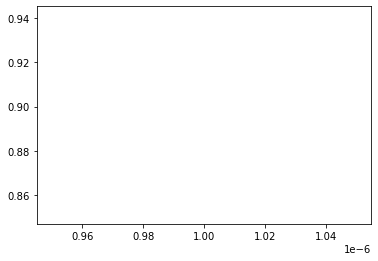

In [15]:
plt.plot(temperatures, errors)
# plt.plot(temperatures, laplace_errors)
plt.show()

In [ ]:
temperatures

[1, 0.5, 0.1, 0.05, 0.01, 0.001]

In [ ]:
errors

array([0.14709255, 0.14719143, 0.15156248, 0.14922862, 0.15336231,
       0.15280854])

In [ ]:
temperature = 1
mdl = NormalModel(weight_distribution = distr,
                bias_distribution = distr)
trainer = BayesModel(train_dataset=train_set,
                test_dataset=val_set,
                batch_size=128,
                architecture=mdl,
                lr=1e-3,
                temperature=temperature)
trainer.fit(n_epochs = 100)

100%|█████████████████████████████████████████| 100/100 [17:26<00:00, 10.47s/it]
